In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import math

## Logistic Regression 


### Images

For this problem we'll use some simple images - a text classfication dataset that is a common ML toy dataset. Up until now we've only used text and numbers for data, how do we deal with images?

We can think of an image as a matrix of pixels. If you ever looked at your TV up extremely close as a kid, you've seen this. Each image here is a 28 by 28 pixel grid, each point on that grid is one pixel that can be somewhere on the black to white scale, which is represented by 0 to 255. So our overall dataset is ~70000 images, each one being a 28 x 28 (784 pixel) x 1 matrix. The only thing making it an image instead of a big table of numbers is how we interpret it when reading the data - if we don't know it is an image, we'd look at it as a bunch of integers; if we know to interpret it as an image, we can use those integers to draw what we were looking for!

If you have a 1080p TV or computer monitor the same logic applies: The screen is a 1920 x 1080 pixel grid, but here each pixel can be multiple colors (there are different color encodings, but the idea is the same) - so instead of each pixel on the grid having a depth of 1 (like our BW digits), each pixel has a depth of 3 - one for each of red, green, and blue, all on a 0 to 255 scale. This allows each pixel to have a position, and a color made up of a combo of those 3 values, giving us a pretty picture. If we were encoding a video, we'd have a series of these images in sequence - with 24, 30, 60 or however many frames per second. 

In [23]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

/Users/akeem/anaconda3/envs/ml_2/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


### Image Data

Our images are currently stored as pixels:
<ul>
<li> Each image is 28 x 28 pixels, so that is 784 total pixels. 
<li> Each individual pixel is a value on a 255 pt scale - greyscale in this case. 
</ul>

Our labels are just the numbers, if we look at a few, each is just a bunch-o-pixels. Overall, the feature set is the pixels and the target is the actual number (the label).

In [24]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Images as Arrays

The above visualization is one of those list of pixels if we picture it. There are 28 x 28 pixels in a 2D grid, and each of those pixels is some degree of "colored". It may be easier to see with a more elaborate image:

![Image Array](images/image_array.jpeg "Image Array" )

All of the "outside" pixels are 0 - black (ours are flipped - black text). Each part of the number has a higher number based on lightness. Our overall image is represented by a 28 x 28 x 1 array - width, height, and "depth" or "color depth", we only have one color (black) so the depth is 1.  This image is pretty low definition, so it is not super clear. The images on our monitors are the same, just with higher definition. We'll look at more elaborate images later, they are stored in the same way, except for color images we have 3 (usually) layers for depth. 

#### Examine an Image

To look at one row of our array in its image form, we can first look at the values from the array, then ask our program to display it as an image. First, we will show an "image", one row of our data, as a 2D array, rather than 1D data in the dataframe. To do so:
<ul>
<li> Grab one row of data. (One image).
    <ul>
    <li> The weird index is because it is a 2D array. We are basically grabing from the "start of 5" to the "start of 6" (non-inclusive).
    </ul>
<li> Reshape that row of 784 pixels into a 28 x 28 array.
<li> Print the numerical values of our 28 x 28 array, arranging them in a grid.
</ul>

In [25]:
X[5:6]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
tmp = np.array(X[5:6]).reshape(28,28)
#sns.heatmap(tmp, cmap='gray')
#print(tmp)
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in tmp]))

0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	13.0	25.0	100.0	122.0	7.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	33.0	151.0	208.0	252.0	252.0	252.0	146.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	40.0	152.0	244.0	252.0	253.0	224.0	211.0	252.0	232.0	40.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	15.0	152.0	239.0	252.0	252.0	25

We can also print its image representation, there's a couple of steps to make it "image-y":
<ul>
<li>Take a row of data from the dataframe. 
<li>Make it into an array - 28 x 28. 
<li>Use mathplotlib to show the array of integers interpreted as an image.
</ul>

There are lots of ways to take image data and display an image, so examples may vary quite a bit. 

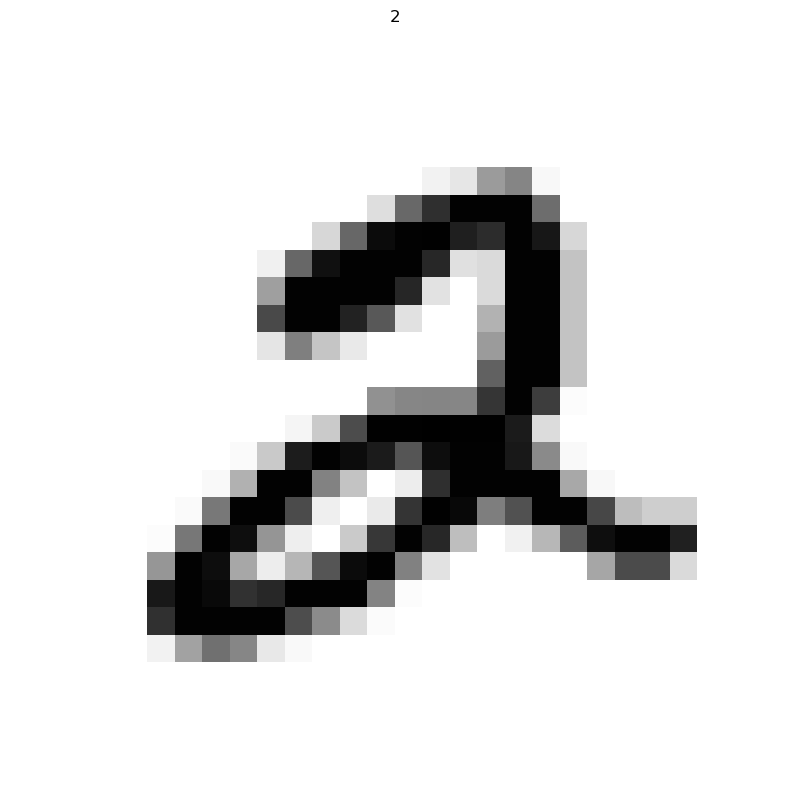

In [27]:
#Look at an image
def showDigit(digit, label, size=28):
    some_digit = digit
    #turn array into the correct shape
    some_digit_image = np.array(some_digit).reshape(size, size)
    #imshow displays an array like an image
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.title(label)
    plt.axis("off")
    plt.show()

showDigit(X[5:6], y[5])

### Color Images

Color images are a little more complicated, but the same idea applies. We have a 3D array, with 3 layers for each pixel. Each layer is a color, and each color is a value on a 0 to 255 scale. We'll deal with color images later, but for now, we can think of them as just 3 of our BW images stacked on top of each other - one layer is each color. 

![RGB Image](images/rgb_image_array.png "RGB Image" )

A color image like this is a similar array as ours, but larger. If the image was 100 x 100 pixels, the array would be 100 x 100 x 3 (1 depth count per color) - this is also something called a tensor, which will be meaningful later. This is why we can do fun stuff with images like facial recognition - images are just big 'ol arrays. This is also why when we start dealing with high definition images or videos, things become MUCH slower; the amount of data in image data grows rapidly the better our images are. 

<b>Note:</b> there are different ways to encode images into data we can store. We won't worry about them, but the ideas are the same for our purposes - the format of the data in the feature set is just different.  

### Show Several Images

We can create a little function that will print out a bunch of images that we can preview. 

In [28]:
#Display multiple digits
def showDigits(digits, labels, indexes, size=28):
    #Make a grid that is the right size
    pics = len(indexes)
    cols = 6
    rows = math.ceil(pics/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14,6))
    plt.axis("off")

    #loop through the list of indexes, grab images and labels, plot in the "next" spot. 
    for i in range(0, pics):
        n = indexes[i]
        some_digit = digits[n:n+1]
        some_digit_image = np.array(some_digit).reshape(size, size)
        ax = axes[i//cols, i%cols]
        ax.axis("off")
        ax.imshow(some_digit_image, cmap=mpl.cm.binary)
        ax.set_title('Ind: {} - Lbl: {}'.format(indexes[i], labels[n]))
    plt.tight_layout()
    plt.axis("off")
    plt.show()

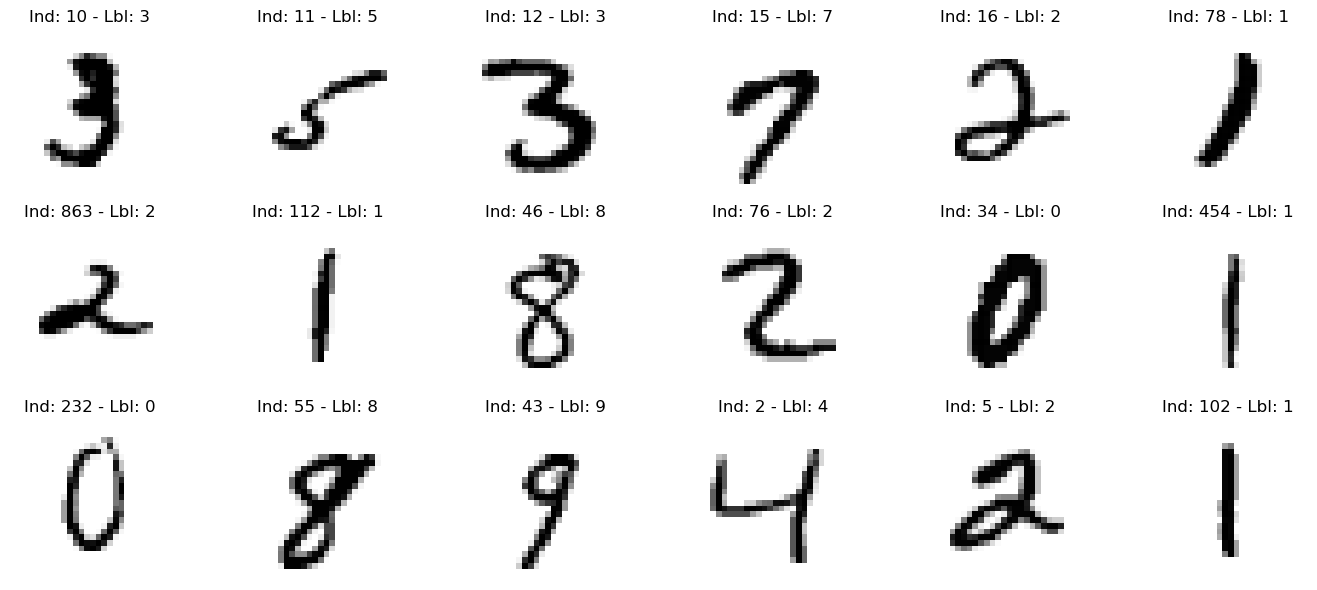

In [29]:
# Random digits. 
showDigits(X, y, [10,11,12,15,16,78,863,112,46,76,34,454,232,55,43,2,5,102])

## Logistic Regression and Images

Like any other data, we can use logistic regression to classify images. 

Our logistic regression is another application of the gradient descent process, since there is no directly calculable solution. Our feature set has 784 features, and we are using each of those features, or pixels, to predict the label. 

### Cost Functions for Classification

As with any gradient descent process, this one will need a cost function that the gradient descent can use to calculate its progress. In regression we generally use some measure of error like MSE/RMSE, but for classification we have a few options.

One note is that the cost function isn't (really) a measure of accuracy (though it is related). The cost function is a measure of how far the model is from the "correct" answer, so the calculations inside of the cost function that measure the accuracy are calculating it based on how close the predictive model is to the correct answer, not just if it is right or wrong. 

#### Log Loss

Log loss is a cost function that is used when we are doing binary classification. It is a measure of how far off our predictions are from the actual values. The formula for log loss is:

 $ \min_{w} C \sum_{i=1}^n \left(-y_i \log(\hat{p}(X_i)) - (1 - y_i) \log(1 - \hat{p}(X_i))\right) + r(w). $

Like the MSE/RMSE cost functions that we use in regression, log loss is a measure of how close our model's prediction is to the true value. Because we are predicting T/F classes, the "true value" is either 0 or 1; our model makes a prediction of a probability that the value is 1 (or the compliment of a prediction that the value is 0). The log loss is based on this difference, the "more strongly" the model predicts that something is True, if it is in actuality true, the lower the error for that prediction. On the flip side, if a value is really 0, the lower the probability the model predicts something is true, the lower the error.

##### Log Loss by Example

Let's say we have a model that predicts the probability that a value is 1. Our data has 8 values, one of which is in each row. We can walk through the log-loss calculation process by looking left to right in the table:

![Log Loss](images/log_loss_ex.png "Log Loss" )

<ul>
<li> The "Actual" column is the true value of the data.
<li> The "Predicted Probabilities" column is the predicted probability that the value is 1.
<li> The "Corrected Probabilities" column is the predicted probability, expressed in terms of the correct value. 
    <ul>
    <li> If the actual value is 1, the predicted probability is the correct probability.
    <li> If the actual value is 0, the predicted probability is the compliment of the correct probability.
    <li> This value is now a measure of "how correct" our prediction is - 1 is perfect, 0 is wrong, and the decimal values are a scale of correctness between the two.
    </ul>
<li> The "Log" column is the log of each of the corrected probabilities. 
</ul>

As these values are negative, we calculate the total log loss by taking the average of the negative log values. If we were to work it all the way through, that is what the intial equation above is. 

This log loss is the cost function that the linear regression will use the gradient descent process to minimize, in just the same way that we used MSE/RMSE in linear regression. As with linear regression, the gradient calculation step of the process "attributes" the log-loss error back to each of the weights, and the gradient descent process uses that to update the weights. Whatever the weights are when the log loss is minimized is the best model for the data. The one odd thing about the log loss is that we have that conditional step where we treat the prediction differently based on the actual value of that instance. If we picture the log loss as a graph, it makes more sense:

![Log Loss](images/logloss.png "Log Loss" )

#### Regularization

One thing to note about logistic regression is that regularization is enabled by default - that default is L2, or Ridge, regualrization. We can change or disable regularization with a hyperparameter.

## Example - Is it a 3? 

We can build a simple model to classify if an image is a 3 or not using logistic regression. Making a model that is processing an image is the same as making a model that is processing text or numbers - we just need to make sure we understand the data:
<ul>
<li> The target is the label, is it a 3 or not.
<li> The features are the pixels, the 64 values that make up the image.
</ul>

So we are doing a simple yes/no logistic regression classification - 64 features in our data, and a 1 or 0 target (is it a 3 or not).

To make this simple, we'll make a new target value, one that matches the goal of our classification - 3 or not 3. 


This dataset is one we can use as an exercise as we go through. It is a smaller version of the images that we are using. Most things translate pretty directly from the example. 

For now:
<ul>
<li>Load the data like we did with mnist. 
<li>Picture a digit, then a grid of digits. 
</ul>

A solved example is below. 

In [30]:
#EXERCISE
#Load Data
from sklearn.datasets import load_digits
digits = load_digits()

These images are 8 x 8, so the resolution is far worse (but the predictions are much faster).

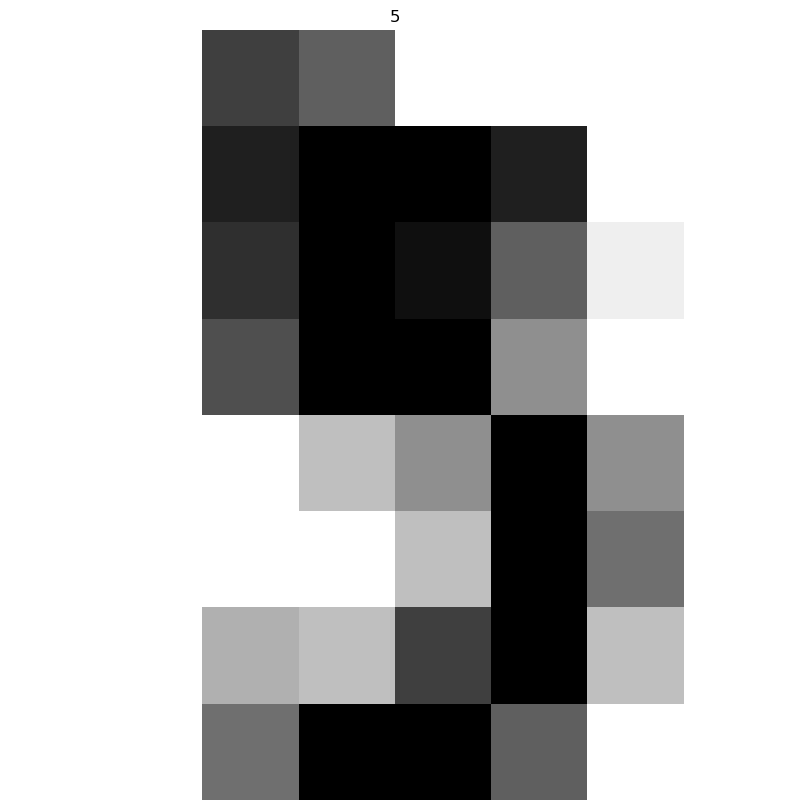

In [31]:
showDigit(digits.data[5:6], digits.target[5], size=8)

Construct the dataset. We need to make a new target value, one that matches the goal of our classification - 3 or not 3. There are lots of ways to do the transformation, I just picked the first that came to mind.

In [32]:
y_3 = (pd.Series(digits.target) == 3)
X_train_dig, X_test_dig, y_train_dig, y_test_dig = train_test_split(digits.data, y_3, test_size=0.3, random_state=42)
X_train_dig.shape, y_train_dig.shape, X_test_dig.shape, y_test_dig.shape

((1257, 64), (1257,), (540, 64), (540,))

Our data is now in a "normal" format for logistic regression - 1 binary target value, and 784 features. We can proceed with the model building process.

In [33]:
scaler = MinMaxScaler()
estimator = LogisticRegression(n_jobs=-1)
pipe = Pipeline(steps=[("scaler", scaler), ("log", estimator)])

pipe.fit(X_train_dig, y_train_dig.ravel())

print("Testing Accuracy:", pipe.score(X_train_dig, y_train_dig))
print("Training Accuracy:", pipe.score(X_test_dig, y_test_dig))

Testing Accuracy: 0.9864757358790772
Training Accuracy: 0.9833333333333333


Since we are doing a classification, we can revisit the confusion matrix to see a breakdown of how our errors occured

<Axes: >

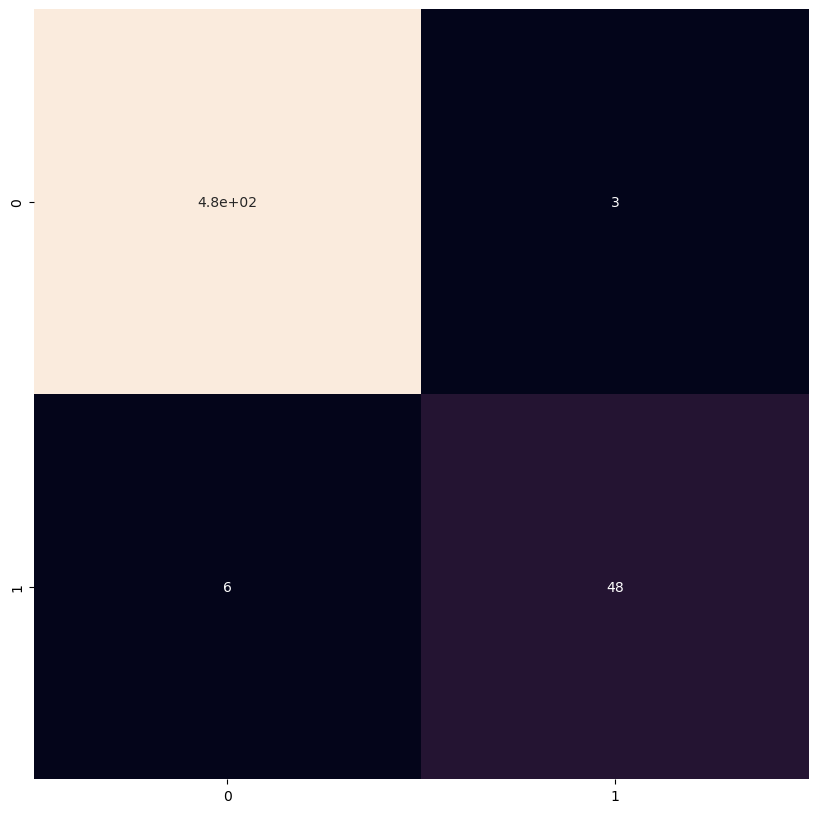

In [34]:
from sklearn.metrics import confusion_matrix

corr = confusion_matrix(y_test_dig,pipe.predict(X_test_dig))
sns.heatmap(corr, annot=True, cbar=False)

Pretty good!

## Exercise - Is it a 9 or 0?

Try an example - is the value a 9 or a 0, or not? So if the value is 9 or 0, the target is 1, otherwise it is 0. You'll need some data prep for this one, not much though. 

<ul>
<li> Value is 9 or 0 = 1. 
<li> Value is 1 through 8 = 0. 
</ul>

## Multiple Classifications - Softmax, One v All, One v One

Logistic regression separated two classes, predictions are either labeled as a 1 or a 0. In reality, we often want to predict more than just yes/no questions. For example, if we are doing facial recognition we likely don't want to settle for saying "yup, that is a person", we want to be able to determine who that person is. 

When we looked at decision trees, they were capable of doing multiple classifications directly, no adjustments needed. Linear classifiers are different though, they only separate between two classes, so we need a different approach. 

![Multi Class](images/multi_class.png "Multi Class" )

### Ways to do Multiple Classifications

There are several different ways to do multiple classifications, here are a couple. 

#### One vs Rest

One way to train a multiple classifier is to create a series of binary clasifiers, one for each outcome class vs "the rest". This is the default in sklearn's logistic regression. The end result is one classifier for each class. 

For our example: 1 vs not 1, 2 vs not 2, etc...

#### One vs One

Another method is to create a separate classifier for every combination of outcomes. This isn't implimented in sklearn's logistic regression but there is a class OneVsOneClassifier that allows you to plug in any classifier and the 1 vs 1 algorithm will be applied. When there are many classes, the number of classifiers and the volume of calculations can be very large, which is why we don't see this one often. 

For our example: 1 vs 2, 1 vs 3, 1 vs 4... 4 vs 5, 4 vs 6....

#### Softmax

For logistic regression, we make these classifications using something called Softmax Regression, or Multinomial Logistic Regression. The idea behind this is pretty simple, we just calculate a score for each class and the highest score is the prediction. 

Softmax will get a bit of a deeper look when we get to neural networks, for now it is more or less a multi-way version of the sigmoid function that we are used to seeing in classfications. Rather than splitting an individual prediction into two possibilites like the sigmoid, the softmax breaks out an individual probability for each of the possible output classes. 

So if we are predicting between 3 classes - A, B, and C, a model that is predicting B with pretty high confidence might produce an output like:
<ul>
<li> A - .228
<li> B - .619
<li> C - .153
</ul>

If the true answer is B, we'd have a real distribution that looks like:
<ul>
<li> A - 0
<li> B - 1
<li> C - 0
</ul>
I.e. the probability of it being B is 100%, since that's the true value; the probability of A or C is 0, because it isn't either of those. 

#### Cross Entropy

Cross entropy is a very common loss function used when doing multiple classifications. 

The cross entropy loss function compares the real distribution to the expected one, and generates a metric for loss (like any other loss function). It will compare the predictions produced by the softmax to the true value and then calculate the loss. If we take the example from above, the cross entropy can be calculated with the formula:

![Cross Entropy](images/cross_ent.png "Cross Entropy" )

Resulting in an actual calculation for the example above of:

 $ H = - (0.0*ln(0.228) + 1.0*ln(0.619) + 0.0*ln(0.153)) = 0.479 $

The gradient descent uses this amount of loss as we'd expect it to, and the training process just keeps repeating until we converge on a minimum amount of loss or run out of iterations to try. There is an expanded explaination here: https://stackoverflow.com/questions/41990250/what-is-cross-entropy/41990932#41990932 

Overll, there is a bit of a two step process as shown above, the logits are calculated, then the softmax is applied to get the probabilities.

![Softmax](images/softmax_multi.png "Softmax" )

We will spend more time on the details of loss stuff in neural networks. 

#### Solver
One of the hyperparameters in the logistic regression call is the solver. This defines the method that the algorithm uses to do the gradient descent. The short answer is that it isn't something that we need to worry about too much unless we are looking for optimizing speed with large datasets. The slightly less short answer is that lbfgs (the default) is probably OK for most cases and either liblinear or saga (large datasets) if we want to feature select using L1 regularization. In any case, don't obsess over this. The documentation provides a little table for selecting an appropriate solver:

![Logistic Regression Solvers](images/log_reg_solvers.png "Logistic Regression Solvers" )

It isn't uncommon to have options like this for some of the model building algorithms. Normally, they are different methods for doing the internal calculations needed to create the model, with the prime difference being efficiency with different types of data. 

<b>Note:</b> there are also "multi-label" classifications, those are classifications that can assign more than one outcome class to a single observation.

## Example - Multi-Class Classification

We can now attempt one of the multi-class classification methods. Most of the code is similar, the main difference here is that we end up with 10 classes instead of the two we are used to. The different methods of doing the multi-class classification can be set via a hyperparameter, we'll try a couple in a grid search.

Our target here is the numerical value, without any transformations, so we have 10 output classes. Other than that, the code is pretty much the same as the binary classification example.

In [35]:
#Classify the digits

# This currently takes the first 10000 images, change commenting to take all
# It may take a long time with all data, especially if there is lots of grid searching and CV
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(X[:10000], y[:10000], test_size=0.3)

# Scale inputs in a pipe
scaler = MinMaxScaler()
estimator = LogisticRegression(n_jobs=-1, solver="saga", max_iter=10000)
pipe = Pipeline(steps=[("scaler", scaler), ("log", estimator)])

# Try different classifications for the multiple classes
params = {'log__multi_class':["ovr","multinomial"]}

clf = GridSearchCV(pipe, param_grid=params, cv=3, n_jobs=-1) 
clf.fit(X_train, y_train.ravel())
best = clf.best_estimator_
train_preds = best.predict(X_train)
print(best)
print(best.score(X_test, y_test))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('log',
                 LogisticRegression(max_iter=10000, multi_class='ovr',
                                    n_jobs=-1, solver='saga'))])
0.9073333333333333


### Classification Results

We can look at the results of our classification, the confusion matrix still works, it is just a little more complex with multiple classes. The intersection shows us the number of times that there was an error between those two classes. 

<b>Note:</b> we can change the commenting below to see half/full of the heatmap. I think that half is easier to understand, since the errors are easier to see and tend to be symmetrical. 

<Axes: >

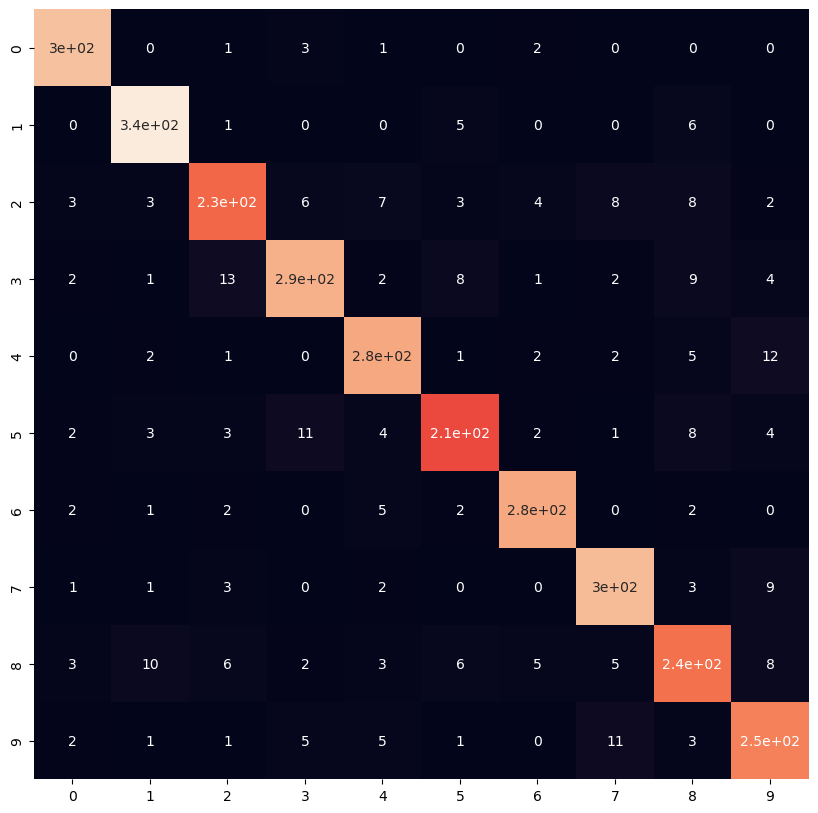

In [36]:
#Create Confusion Matrix
from sklearn.metrics import confusion_matrix
plt.rcParams["figure.figsize"] = (10,10)

preds = best.predict(X_test)

corr = confusion_matrix(y_test,preds)
#mask = np.triu(np.ones_like(corr, dtype=bool))
#sns.heatmap(corr, annot=True, mask=mask)
sns.heatmap(corr, annot=True, cbar=False)

We can take a look at the heatmap to see how often we are wrong with different combinations of digits. For example, 7 and 9 having frequent errors isn't every surprising. 

The confustion matrix is a 2D array of counts of errors. We can extract the values for each number to look at the differences in performance for each digit. 

In [37]:
print(corr)

# Grab each row, which represents one digit, and add up the errors. 
# Be sure to exclude the "spine" of counts. 
ers = []
for i in range(len(corr)):
    num = corr[i]
    #print(num)
    before = num[:i]
    after = num[i+1:]
    #print(before, after)
    tmp_err = np.sum(before) + np.sum(after)
    ers.append(tmp_err)
print(ers)

[[302   0   1   3   1   0   2   0   0   0]
 [  0 340   1   0   0   5   0   0   6   0]
 [  3   3 232   6   7   3   4   8   8   2]
 [  2   1  13 289   2   8   1   2   9   4]
 [  0   2   1   0 281   1   2   2   5  12]
 [  2   3   3  11   4 211   2   1   8   4]
 [  2   1   2   0   5   2 281   0   2   0]
 [  1   1   3   0   2   0   0 297   3   9]
 [  3  10   6   2   3   6   5   5 239   8]
 [  2   1   1   5   5   1   0  11   3 250]]
[7, 12, 44, 42, 25, 38, 14, 19, 48, 29]


Text(0.5, 1.0, 'Errors Per Number')

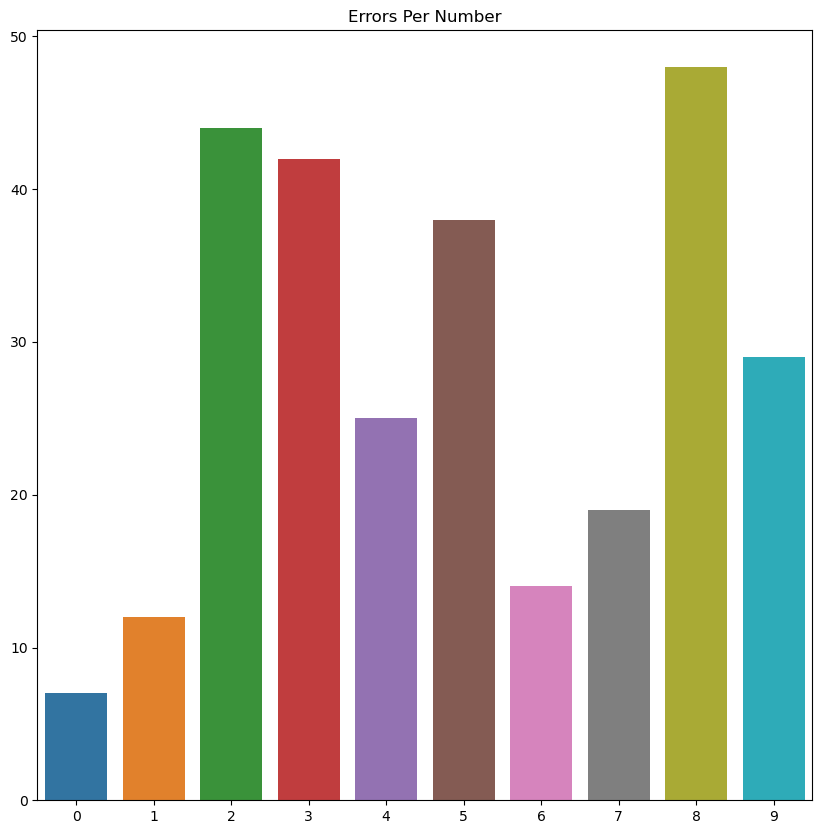

In [38]:
#Errors Per Number
sns.barplot(y=ers, x=[0,1,2,3,4,5,6,7,8,9])
plt.title("Errors Per Number")

### Error Distribution

As we might expect the errors are skewed towards numbers that look similar, like a 6 and an 8. There's no intuitive way to know what we can do with our modeling to improve this - maybe some different algorithm gives better results, or a different set of HPs that we can find with a grid search. 

Most likely we'll need to do some processing of the data to understand them a little better as images rather than just tables of pixels. Image processing is something we'll look into a little bit more later on in the course. Real image processing for machine learning often involves doing something to process the data and extract features that are more useful; for example, with navigation or vision of the "real world", image processing steps are often used to extract features like edges, which can define things like the boundaries of roads or cars. 

## Exercise - Multi-Class Classification

Try with a slightly more simple example - an 8 x 8 version of the same thing.

In [39]:
#Load Data
from sklearn.datasets import load_digits
digits = load_digits()
Xd, yd = digits["data"], digits["target"]
print(Xd.shape)
print(yd.shape)

(1797, 64)
(1797,)


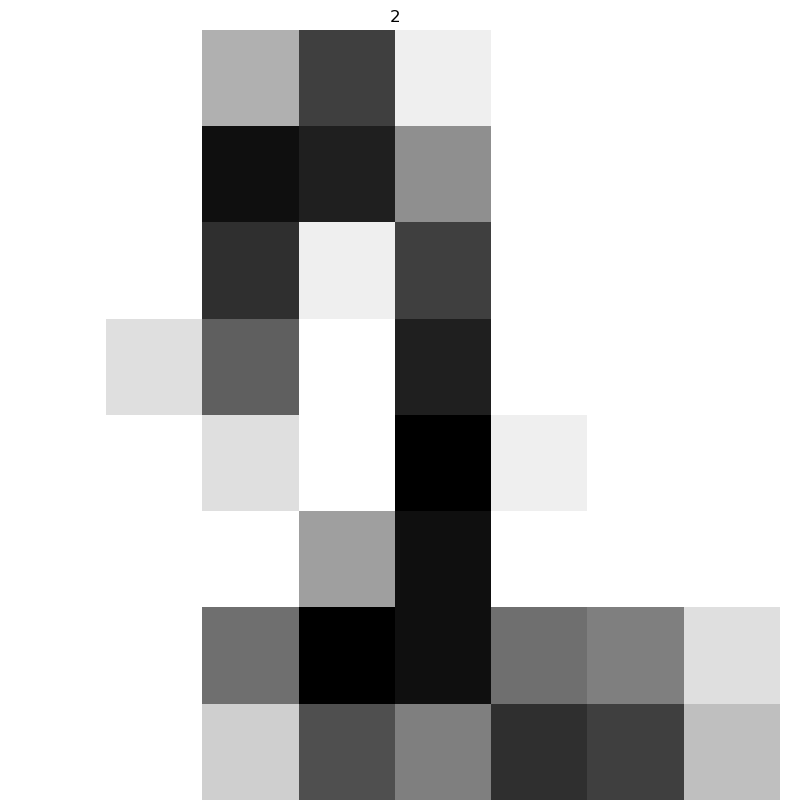

In [40]:
#Look at a digit
showDigit(Xd[12:13], yd[12], 8)

In [41]:
#Classify the digits

Print a confusion matrix, I'll use the mask here to only show half of the matrix.

In [42]:
#Create Confusion Matrix


### Too Simple? Try on the MNIST Dataset

Do a multi-class classification on the MNIST dataset. You may need to take a sample of the data, as it can take a while to run.